In [1]:
#  Use the appropriate install depending on your local directory

##%pip install --quiet -U pip -r ../requirements/requirements-train.txt ../.

#%pip install --quiet -U pip -r ./requirements/requirements-train.txt ./.

In [2]:
import pickle
import jax
from hydra import compose, initialize

#export PATH="~/Documents/InstadeepGroupProject/jumanji_routing"
from jumanji.training.setup_train import setup_agent, setup_env
from jumanji.training.utils import first_from_device

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
import numpy as np
import chex
import jax.numpy as jnp
import jumanji
from typing import Dict

from jumanji.environments import Connector
from jumanji.environments.routing.connector.types import Agent, Observation, State
from jumanji.types import TimeStep
from jumanji.environments.routing.connector.utils import get_position, get_target
from ic_routing_board_generation.board_generator.jax_board_generation.board_generator_random_seed_rb import RandomSeedBoard
from ic_routing_board_generation.board_generator.numpy_utils.utils import get_heads_and_targets
from ic_routing_board_generation.interface.board_generator_interface_numpy import BoardGenerator, BoardName
from datetime import datetime
from copy import deepcopy

In [4]:
from ic_routing_board_generation.board_generator.numpy_utils.post_processor_utils_numpy import \
    training_board_from_solved_board, extend_wires, count_detours
from ic_routing_board_generation.board_generator.jax_utils.post_processor_utils_jax import \
    training_board_from_solved_board_jax, extend_wires_jax

## Load configs

In [5]:
#with initialize(version_base=None, config_path="../jumanji/training/configs"):
    #cfg = compose(config_name="config.yaml", overrides=["env=connector", "agent=a2c"])
with initialize(version_base=None, config_path="./jumanji/training/configs"):
    cfg = compose(config_name="config.yaml", overrides=["env=connector", "agent=a2c"])
cfg

{'agent': 'a2c', 'seed': 0, 'logger': {'type': 'terminal', 'save_checkpoint': False, 'name': '${agent}_${env.name}'}, 'env': {'name': 'connector', 'registered_version': 'Connector-v0', 'network': {'transformer_num_blocks': 4, 'transformer_num_heads': 8, 'transformer_key_size': 16, 'transformer_mlp_units': [512], 'conv_n_channels': 32}, 'training': {'num_epochs': 500, 'num_learner_steps_per_epoch': 100, 'n_steps': 20, 'total_batch_size': 128}, 'evaluation': {'eval_total_batch_size': 5000, 'greedy_eval_total_batch_size': 5000}, 'a2c': {'normalize_advantage': False, 'discount_factor': 0.99, 'bootstrapping_factor': 0.95, 'l_pg': 1.0, 'l_td': 1.0, 'l_en': 0.01, 'learning_rate': 0.0002}}}

## Load a saved checkpoint

In [6]:
file = "examples/trained_agent_10x10_5_uniform/19-27-36/training_state_10x10_5_uniform"
#file = "examples/training_state_8x8_5_uniform"
#file = "examples/training_state_10x10_5_randomwalk"
with open(file,"rb") as f:
    training_state = pickle.load(f)

params = first_from_device(training_state.params_state.params)
#print(params)
env = setup_env(cfg).unwrapped
#print(env)
agent = setup_agent(cfg, env)
#print(agent)
policy = jax.jit(agent.make_policy(params.actor, stochastic = False))
#print(params.num_agents)
#print(policy)


# Roll out a few episodes of their default "uniform" board generation

In [7]:
step_fn = jax.jit(env.step)  # Speed up env.step
GRID_SIZE = 10
NUM_AGENTS = 5
NUM_EPISODES = 10 # 10000

print(datetime.now())
states = []
key = jax.random.PRNGKey(cfg.seed)

connections = []
for episode in range(NUM_EPISODES):  
    key, reset_key = jax.random.split(key)
    state, timestep = jax.jit(env.reset)(reset_key)   

    while not timestep.last():
        key, action_key = jax.random.split(key)
        observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
        # Two implementations for calling the policy, about equivalent speed
        action, _ = policy(observation, action_key)
        #action, _ = jax.jit(policy)(observation, action_key)
        # Three implementations for updating the state/timestep.  The third is much faster.
        #state, timestep = jax.jit(env.step)(state, action.squeeze(axis=0)) # original jit = 0.32, 52sec/10
        #state, timestep = env.step(state, action.squeeze(axis=0)) # no jit = 0.13, 26sec/10
        state, timestep = step_fn(state, action.squeeze(axis=0)) # jit function = 0.003 5 sec/10, 49sec/100d
        states.append(state)
    # Freeze the terminal frame to pause the GIF.
    for _ in range(10):
        states.append(state)
        
    #################################################
    # Evaluate the number of wires connected
    num_connected = timestep.extras["num_connections"]
    connections.append(num_connected)

#print(connections)
connections = np.array (connections)
print(f"{NUM_EPISODES} Evaluations: Average connections for default Uniform board = {connections.mean()}, std={connections.std()}")
print(datetime.now())

2023-04-27 19:08:53.967205
10 Evaluations: Average connections for default Uniform board = 3.8, std=0.8717797887081347
2023-04-27 19:08:59.531489


2023-04-15 20:04:46.888987
Average connections for default Uniform board = 4.14, std=0.8834025130143109
2023-04-15 20:05:35.859778

1000 evals = 7 min
2023-04-15 23:32:21.077616
Average connections for default Uniform board = 4.048, std=0.8908961780140264
2023-04-15 23:39:18.525824

10000 evals = 1hr 9 min 37sec
2023-04-15 23:47:56.598269
Average connections for default Uniform board = 4.0287, std=0.8960336545018832
2023-04-16 00:57:33.757044


## Rollout a few episodes of each of our board generators

In [ ]:
# Keep this cell
#from ic_routing_board_generation.board_generator.board_generator_random_seed_rb import RandomSeedBoard

step_fn = jax.jit(env.step) # Speed up env.step
BOARD_GENERATORS = [
        BoardName.BFS_BASE,
        BoardName.BFS_MIN_BENDS,
        BoardName.BFS_FIFO,
        BoardName.BFS_SHORTEST,
        BoardName.BFS_LONGEST,
        BoardName.RANDOM_WALK,
        BoardName.RANDOM_SEED,
        BoardName.LSYSTEMS,
        BoardName.WFC,
        BoardName.NUMBERLINK]

GRID_SIZE = 10
NUM_AGENTS = 5

NUM_EPISODES = 10 # 10000

print(datetime.now())
states = []
key = jax.random.PRNGKey(cfg.seed)

for BOARD_GENERATOR in [BoardName.RANDOM_SEED]:   # BOARD_GENERATORS:
    print(BOARD_GENERATOR) 
    for episode in range(NUM_EPISODES):
   
        key, reset_key = jax.random.split(key)
        #### Copied from ic_rl_training ###################################
        # Create empty grid.
        grid = jnp.zeros((GRID_SIZE, GRID_SIZE), dtype=jnp.int32)

        board_class = BoardGenerator.get_board_generator(
            board_enum=BOARD_GENERATOR)    

        if (BOARD_GENERATOR == BoardName.RANDOM_SEED):
            key, subkey = jax.random.split(key)
            board = RandomSeedBoard(GRID_SIZE, GRID_SIZE, NUM_AGENTS)
            jaxd_board_init = jax.jit(board.return_solved_board)
            solved_board = jaxd_board_init(subkey)
            #key, subkey = jax.random.split(key)
            #solved_board = jaxd_board_init(subkey)
            #solved_board = jax.jit(board.return_solved_board)(subkey)
            #print(solved_board)
            #starts, targets = jax.jit(board.generate_starts_ends)(subkey)
            #print(starts, targets)
            #pins = jax.jit(board.return_training_board)(subkey)
            #print(pins)
        else:
            board = board_class(GRID_SIZE, GRID_SIZE, NUM_AGENTS)
            print(board.return_solved_board())
            pins = board.return_training_board()
        """
        starts_flat, targets_flat = get_heads_and_targets(pins)
        starts = jnp.divmod(starts_flat, GRID_SIZE)
        targets = jnp.divmod(targets_flat, GRID_SIZE)

        agent_position_values = jax.vmap(get_position)(jnp.arange(NUM_AGENTS))
        agent_target_values = jax.vmap(get_target)(jnp.arange(NUM_AGENTS))

        # Place the agent values at starts and targets.
        grid = grid.at[starts].set(agent_position_values)
        grid = grid.at[targets].set(agent_target_values)

        # Create the agent pytree that corresponds to the grid.
        agents = jax.vmap(Agent)(
            id=jnp.arange(NUM_AGENTS),
            start=jnp.stack(starts, axis=1),
            target=jnp.stack(targets, axis=1),
            position=jnp.stack(starts, axis=1),
        )
        step_count = jnp.array(0, jnp.int32)
        state = State(key=key, grid=grid, step_count=step_count, agents=agents)
        ### END OF CODE FROM IC_RL_TRAINING  ##################################
       
        
        ### AMENDMENT 2 FROM CLEMENT TO INITIALIZE TIMESTEP #################
        action_mask = jax.vmap(env._get_action_mask, (0, None))(
            state.agents, state.grid
            )
        observation = Observation(
            grid=env._obs_from_grid(state.grid),
            action_mask=action_mask,
            step_count=state.step_count,
            )
        extras = env._get_extras(state)
        timestep = jumanji.types.restart(
            observation=observation, extras=extras, shape=(env.num_agents,)
            )
        ####################################################################
        
        while not timestep.last():
            key, action_key = jax.random.split(key)
            observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
            # Two implementations for calling the policy, about equivalent speed
            #action, _ = policy(observation, action_key)
            action, _ = jax.jit(policy)(observation, action_key)
            # Three implementations for updating the state/timestep.  The third is much faster.
            #state, timestep = jax.jit(env.step)(state, action.squeeze(axis=0)) # original jit = 0.32, 52sec/10
            #state, timestep = env.step(state, action.squeeze(axis=0)) # no jit = 0.13, 26sec/10
            state, timestep = step_fn(state, action.squeeze(axis=0)) # jit function = 0.003 5 sec/10, 49sec/100d
            states.append(state)
        # Freeze the terminal frame to pause the GIF.
        for _ in range(10):
            states.append(state)
            
        # Evaluate the number of wires connected
        num_connected = timestep.extras["num_connections"]
        connections.append(num_connected)
    connections = np.array(connections)
    print(f"{NUM_EPISODES} Evaluations: Average connections for {BOARD_GENERATOR} = {connections.mean()}, std={connections.std()}")
        """
    print(datetime.now())

In [ ]:
# Extend the randomseed in this cell
from ic_routing_board_generation.board_generator.board_generator_random_seed_rb import RandomSeedBoard

step_fn = jax.jit(env.step) # Speed up env.step
BOARD_GENERATORS = [
        BoardName.BFS_BASE,
        BoardName.BFS_MIN_BENDS,
        BoardName.BFS_FIFO,
        BoardName.BFS_SHORTEST,
        BoardName.BFS_LONGEST,
        BoardName.RANDOM_WALK,
        BoardName.RANDOM_SEED,
        BoardName.LSYSTEMS,
        BoardName.WFC,
        BoardName.NUMBERLINK]

GRID_SIZE = 10
NUM_AGENTS = 5

NUM_EPISODES = 1000 # 10000

print(datetime.now())
states = []
connections = []
key = jax.random.PRNGKey(cfg.seed)

for BOARD_GENERATOR in [BoardName.RANDOM_SEED]:   # BOARD_GENERATORS:
    print(BOARD_GENERATOR)         
    if (BOARD_GENERATOR == BoardName.RANDOM_SEED):
        board = RandomSeedBoard(GRID_SIZE, GRID_SIZE, NUM_AGENTS)
        #jaxd_board_init = jax.jit(board.return_solved_board)
        #extended_board_init = jax.jit(board.return_extended_board)

    for episode in range(NUM_EPISODES):
   
        key, reset_key = jax.random.split(key)
        #### Copied from ic_rl_training ###################################
        # Create empty grid.
        grid = jnp.zeros((GRID_SIZE, GRID_SIZE), dtype=jnp.int32)

        board_class = BoardGenerator.get_board_generator(
            board_enum=BOARD_GENERATOR)    

        if (BOARD_GENERATOR == BoardName.RANDOM_SEED):
            key, subkey = jax.random.split(key)
            solved_board = jaxd_board_init(subkey)
            #print(solved_board)
            #extended_board_straight = extended_board_init(subkey, 0.0)
            #print(extended_board_straight)
            #extended_board_5050 = extended_board_init(subkey, 0.5)
            #print(extended_board_5050)
            #extended_board_random = extended_board_init(subkey, 1.0)
            #print(extended_board_random)
            extended_board = extended_board_init(subkey, 0.0)
            #starts, targets = jax.jit(board.generate_starts_ends)(subkey)
            #print(starts, targets)
            #pins = jax.jit(board.return_training_board)(subkey)
            #print(pins)
            pins = np.array(extended_board)
            rows, cols = extended_board.shape
            for row in range(rows):
                for col in range (cols):
                    if (pins[row, col] % 3) == 1:  # PATH cell
                        pins[row, col] = 0
            #print(pins)
        else:
            board = board_class(GRID_SIZE, GRID_SIZE, NUM_AGENTS)
            print(board.return_solved_board())
            pins = board.return_training_board()
        
        starts_flat, targets_flat = get_heads_and_targets(pins)
        starts = jnp.divmod(starts_flat, GRID_SIZE)
        targets = jnp.divmod(targets_flat, GRID_SIZE)

        agent_position_values = jax.vmap(get_position)(jnp.arange(NUM_AGENTS))
        agent_target_values = jax.vmap(get_target)(jnp.arange(NUM_AGENTS))

        # Place the agent values at starts and targets.
        grid = grid.at[starts].set(agent_position_values)
        grid = grid.at[targets].set(agent_target_values)

        # Create the agent pytree that corresponds to the grid.
        agents = jax.vmap(Agent)(
            id=jnp.arange(NUM_AGENTS),
            start=jnp.stack(starts, axis=1),
            target=jnp.stack(targets, axis=1),
            position=jnp.stack(starts, axis=1),
        )
        step_count = jnp.array(0, jnp.int32)
        state = State(key=key, grid=grid, step_count=step_count, agents=agents)
        ### END OF CODE FROM IC_RL_TRAINING  ##################################
       
        
        ### AMENDMENT 2 FROM CLEMENT TO INITIALIZE TIMESTEP #################
        action_mask = jax.vmap(env._get_action_mask, (0, None))(
            state.agents, state.grid
            )
        observation = Observation(
            grid=env._obs_from_grid(state.grid),
            action_mask=action_mask,
            step_count=state.step_count,
            )
        extras = env._get_extras(state)
        timestep = jumanji.types.restart(
            observation=observation, extras=extras, shape=(env.num_agents,)
            )
        ####################################################################
        
        while not timestep.last():
            key, action_key = jax.random.split(key)
            observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
            # Two implementations for calling the policy, about equivalent speed
            #action, _ = policy(observation, action_key)
            action, _ = jax.jit(policy)(observation, action_key)
            # Three implementations for updating the state/timestep.  The third is much faster.
            #state, timestep = jax.jit(env.step)(state, action.squeeze(axis=0)) # original jit = 0.32, 52sec/10
            #state, timestep = env.step(state, action.squeeze(axis=0)) # no jit = 0.13, 26sec/10
            state, timestep = step_fn(state, action.squeeze(axis=0)) # jit function = 0.003 5 sec/10, 49sec/100d
            states.append(state)
        # Freeze the terminal frame to pause the GIF.
        for _ in range(10):
            states.append(state)
            
        # Evaluate the number of wires connected
        num_connected = timestep.extras["num_connections"]
        connections.append(num_connected)
    connections = np.array(connections)
    print(f"{NUM_EPISODES} Evaluations: Average connections for {BOARD_GENERATOR} = {connections.mean()}, std={connections.std()}")
        
    print(datetime.now())

SAVE SOME RESULTS, HOW THE "UNIFORM AGENT" PERFORMS ON 
RANDOMSEED-EXTEND-RANDOM
2023-04-20 22:12:47.813589
BoardName.RANDOM_SEED
1000 Evaluations: Average connections for random_seed = 4.407, std=0.7164851708165355
2023-04-20 22:14:08.681154

RANDOMSEED-EXTEND-STRAIGHT
2023-04-20 22:20:19.895471
BoardName.RANDOM_SEED
1000 Evaluations: Average connections for random_seed = 4.454, std=0.7401918670182752
2023-04-20 22:21:44.037252


10000 evals = 1hr 8min 11sec/5 = 14min/generator
2023-04-16 00:57:33.807103
BoardName.BFS_BASE
Average connections for bfs_base = 4.5573, std=0.6149119530469382
2023-04-16 01:12:05.259665
BoardName.BFS_MIN_BENDS
Average connections for bfs_min_bend = 4.5019, std=0.6561984379743676
2023-04-16 01:25:57.235825
BoardName.BFS_FIFO
Average connections for bfs_fifo = 4.6212, std=0.5790600659689804
2023-04-16 01:39:11.518756
BoardName.BFS_SHORTEST
Average connections for bfs_short = 4.4307, std=0.6763116958917685
2023-04-16 01:52:50.729754
BoardName.BFS_LONGEST
Average connections for bfs_long = 4.717, std=0.5172146556314892
2023-04-16 02:05:44.179665
BoardName.RANDOM_WALK

10000 Evals = 2hr 3min 27sec
WFC = 1hr 5min 19sec, other four =58/4 = 14.5min/generator
2023-04-16 07:54:41.199665
BoardName.BFS_LONGEST
10000 Evaluation: Average connections for default Uniform board = 4.7163, std=0.5147954059624076
Average connections for bfs_long = 4.7163, std=0.5147954059624076
2023-04-16 08:07:22.442150
BoardName.RANDOM_WALK
10000 Evaluation: Average connections for default Uniform board = 4.676, std=0.5460988921431722
Average connections for random_walk = 4.676, std=0.5460988921431722
2023-04-16 08:19:17.594845
BoardName.LSYSTEMS_STANDARD
10000 Evaluation: Average connections for default Uniform board = 4.9944, std=0.07725697379525037
Average connections for lsystems_standard = 4.9944, std=0.07725697379525037
2023-04-16 08:28:43.780898
BoardName.WFC
10000 Evaluation: Average connections for default Uniform board = 4.833, std=0.4085474268674324
Average connections for wfc = 4.833, std=0.4085474268674324
2023-04-16 09:34:02.631164
BoardName.NUMBERLINK
10000 Evaluation: Average connections for default Uniform board = 4.0041, std=0.9051426351686236
Average connections for numberlink = 4.0041, std=0.9051426351686236
2023-04-16 09:58:08.309304

# Roll out a few episodes, extending the wires of each board generator

In [ ]:
step_fn = jax.jit(env.step) #  Speed up env.step
BOARD_GENERATORS = [
        BoardName.BFS_BASE,
        BoardName.BFS_MIN_BENDS,
        BoardName.BFS_FIFO,
        BoardName.BFS_SHORTEST,
        BoardName.BFS_LONGEST,
        BoardName.RANDOM_WALK,
        BoardName.LSYSTEMS,
        BoardName.WFC,
        BoardName.NUMBERLINK]

GRID_SIZE = 10
NUM_AGENTS = 5
NUM_EPISODES = 1 # 10000

print(datetime.now())
states = []
key = jax.random.PRNGKey(cfg.seed)

for BOARD_GENERATOR in BOARD_GENERATORS:
    print(BOARD_GENERATOR)
    connections = []
    detours_raw = []
    detours_extended = []
    for episode in range(NUM_EPISODES):
   
        key, reset_key = jax.random.split(key)


        ### Copied from ic_rl_training  ##########################
        # Create empty grid.
        grid = jnp.zeros((GRID_SIZE, GRID_SIZE), dtype=jnp.int32)

        board_class = BoardGenerator.get_board_generator(
            board_enum=BOARD_GENERATOR)    
        board = board_class(GRID_SIZE, GRID_SIZE, NUM_AGENTS)
        pins = board.return_training_board()

        ### WIRE EXTENSION #####
        #print("PINS")
        #print(pins)
        board_solved = board.return_solved_board()
        detours_raw.append(count_detours(board_solved, False))
        #print("BOARD SOLVED")
        #print(board_solved)
        board_extended = extend_wires(board_solved)
        detours_extended.append(count_detours(board_extended, False))
        #print("BOARD EXTENDED")
        #print(board_extended)
        pins = training_board_from_solved_board_jax(board_extended)
        #print("PINS EXTENDED")
        #print(pins)
        ### END OF WIRE EXTENSION ####

        starts_flat, targets_flat = get_heads_and_targets(pins)
        starts = jnp.divmod(starts_flat, GRID_SIZE)
        targets = jnp.divmod(targets_flat, GRID_SIZE)

        agent_position_values = jax.vmap(get_position)(jnp.arange(NUM_AGENTS))
        agent_target_values = jax.vmap(get_target)(jnp.arange(NUM_AGENTS))

        # Place the agent values at starts and targets.
        grid = grid.at[starts].set(agent_position_values)
        grid = grid.at[targets].set(agent_target_values)

        # Create the agent pytree that corresponds to the grid.
        agents = jax.vmap(Agent)(
            id=jnp.arange(NUM_AGENTS),
            start=jnp.stack(starts, axis=1),
            target=jnp.stack(targets, axis=1),
            position=jnp.stack(starts, axis=1),
        )

        step_count = jnp.array(0, jnp.int32)

        state = State(key=key, grid=grid, step_count=step_count, agents=agents)
        # END OF CODE FROM IC_RL_TRAINING
        ########################################################################################

        
        ###############AMENDMENT 2 FROM CLEMENT TO INITIALIZE TIMESTEP############################
        action_mask = jax.vmap(env._get_action_mask, (0, None))(
            state.agents, state.grid
            )
        observation = Observation(
            grid=env._obs_from_grid(state.grid),
            action_mask=action_mask,
            step_count=state.step_count,
            )
        extras = env._get_extras(state)
        timestep = jumanji.types.restart(
            observation=observation, extras=extras, shape=(env.num_agents,)
            )
        ####################################################################
        
        
        while not timestep.last():
            key, action_key = jax.random.split(key)
            observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
            # Two implementations for calling the policy, about equivalent speed
            #action, _ = policy(observation, action_key)
            action, _ = jax.jit(policy)(observation, action_key)
            # Three implementations for updating the state/timestep.  The third is much faster.
            #state, timestep = jax.jit(env.step)(state, action.squeeze(axis=0)) # original jit = 0.32, 52sec/10
            #state, timestep = env.step(state, action.squeeze(axis=0)) # no jit = 0.13, 26sec/10
            state, timestep = step_fn(state, action.squeeze(axis=0)) # jit function = 0.003 5 sec/10, 49sec/100d
            states.append(state)
        # Freeze the terminal frame to pause the GIF.
        for _ in range(10):
            states.append(state)

        # Evaluate the number of wires connected
        num_connected = timestep.extras["num_connections"]
        connections.append(num_connected)

    connections = np.array(connections)
    print(f"{NUM_EPISODES} Evaluations: Average connections for {BOARD_GENERATOR} = {connections.mean()}, std={connections.std()}")
    detours_raw = np.array(detours_raw)    
    print(f"Average Detours (RAW) = {detours_raw.mean()}, (std = {detours_raw.std()}) ")
    detours_extended = np.array(detours_extended)
    print(f"Average Detours (extended) = {detours_extended.mean()}, (std = {detours_extended.std()}) ")
    print(datetime.now())

SAVING SOME TEST RESULTS

10000 evals, L-systems
2023-04-17 13:20:00.211418
BoardName.LSYSTEMS_STANDARD
10000 Evaluations: Average connections for lsystems_standard = 4.3941, std=0.7488559207217367
2023-04-17 13:36:50.571677

1000 evals, all our boards
2023-04-17 13:53:54.225413
BoardName.BFS_BASE
1000 Evaluations: Average connections for bfs_base = 4.202, std=0.8019950124533194
2023-04-17 13:55:53.485387
BoardName.BFS_MIN_BENDS
1000 Evaluations: Average connections for bfs_min_bend = 4.08, std=0.8874683092933515
2023-04-17 13:58:03.262815
BoardName.BFS_FIFO
1000 Evaluations: Average connections for bfs_fifo = 4.19, std=0.8293973715897585
2023-04-17 14:00:14.402026
BoardName.BFS_SHORTEST
1000 Evaluations: Average connections for bfs_short = 4.109, std=0.8712743540355128
2023-04-17 14:02:29.357893
BoardName.BFS_LONGEST
1000 Evaluations: Average connections for bfs_long = 4.251, std=0.8087020464917842
2023-04-17 14:04:44.767001
BoardName.RANDOM_WALK
1000 Evaluations: Average connections for random_walk = 4.478, std=0.6822873295027544
2023-04-17 14:06:33.586283
BoardName.LSYSTEMS_STANDARD
1000 Evaluations: Average connections for lsystems_standard = 4.385, std=0.7475125417008066
2023-04-17 14:08:31.457369
BoardName.WFC
1000 Evaluations: Average connections for wfc = 4.53, std=0.6731270311018568
2023-04-17 14:15:43.012756
BoardName.NUMBERLINK
1000 Evaluations: Average connections for numberlink = 4.038, std=0.9124450668396425
2023-04-17 14:18:42.103116


10000 Evals
2023-04-18 00:19:31.909775
BoardName.BFS_BASE
10000 Evaluations: Average connections for bfs_base = 4.1471, std=0.8551383455324642
Average Detours (RAW) = 1.3449, (std = 1.8076349161265943) 
Average Detours (RAW) = 5.5036, (std = 3.7273834039443807) 
2023-04-18 00:38:01.948714
BoardName.BFS_MIN_BENDS
10000 Evaluations: Average connections for bfs_min_bend = 4.1253, std=0.8566212173417138
Average Detours (RAW) = 1.9149, (std = 2.1955085948362854) 
Average Detours (RAW) = 5.9369, (std = 3.7803066529052907) 
2023-04-18 00:58:03.050593
BoardName.BFS_FIFO
10000 Evaluations: Average connections for bfs_fifo = 4.1664, std=0.854699385749165
Average Detours (RAW) = 1.4981, (std = 1.9647891464480356) 
Average Detours (RAW) = 5.5746, (std = 3.694703620048569) 
2023-04-18 01:17:46.139231
BoardName.BFS_SHORTEST
10000 Evaluations: Average connections for bfs_short = 4.101, std=0.8699419520864596
Average Detours (RAW) = 1.6461, (std = 1.9280702243435013) 
Average Detours (RAW) = 5.6776, (std = 3.646677698947358) 
2023-04-18 01:37:43.132813
BoardName.BFS_LONGEST






ALSO WITH COMPARISION OF NUM_DETOURS

2023-04-17 14:41:57.356808
BoardName.BFS_BASE
10 Evaluations: Average connections for bfs_base = 4.0, std=0.8944271909999159
Average Detours (RAW) = 0.9, (std = 1.5132745950421556) 
Average Detours (RAW) = 5.0, (std = 2.7202941017470885) 
2023-04-17 14:41:58.981720
BoardName.BFS_MIN_BENDS
10 Evaluations: Average connections for bfs_min_bend = 4.2, std=1.1661903789690602
Average Detours (RAW) = 2.2, (std = 1.661324772583615) 
Average Detours (RAW) = 5.4, (std = 1.6852299546352716) 
2023-04-17 14:42:00.139787
BoardName.BFS_FIFO
10 Evaluations: Average connections for bfs_fifo = 4.6, std=0.6633249580710799
Average Detours (RAW) = 1.5, (std = 2.5) 
Average Detours (RAW) = 5.0, (std = 3.9749213828703582) 
2023-04-17 14:42:01.258899
BoardName.BFS_SHORTEST
10 Evaluations: Average connections for bfs_short = 3.9, std=1.2206555615733705
Average Detours (RAW) = 2.9, (std = 3.5902646142032486) 
Average Detours (RAW) = 6.8, (std = 4.791659420284375) 
2023-04-17 14:42:02.465300
BoardName.BFS_LONGEST
10 Evaluations: Average connections for bfs_long = 4.4, std=0.8
Average Detours (RAW) = 1.1, (std = 1.5132745950421556) 
Average Detours (RAW) = 5.4, (std = 2.939387691339814) 
2023-04-17 14:42:03.647215
BoardName.RANDOM_WALK
10 Evaluations: Average connections for random_walk = 4.3, std=0.7810249675906654
Average Detours (RAW) = 3.1, (std = 1.7) 
Average Detours (RAW) = 4.3, (std = 2.0518284528683193) 
2023-04-17 14:42:04.609534
BoardName.LSYSTEMS_STANDARD
10 Evaluations: Average connections for lsystems_standard = 4.1, std=1.1357816691600546
Average Detours (RAW) = 0.0, (std = 0.0) 
Average Detours (RAW) = 2.6, (std = 1.5620499351813308) 
2023-04-17 14:42:05.545080
BoardName.WFC
10 Evaluations: Average connections for wfc = 4.3, std=0.6403124237432849
Average Detours (RAW) = 1.2, (std = 1.32664991614216) 
Average Detours (RAW) = 2.5, (std = 1.857417562100671) 
2023-04-17 14:42:09.540836
BoardName.NUMBERLINK
10 Evaluations: Average connections for numberlink = 4.2, std=0.9797958971132713
Average Detours (RAW) = 16.7, (std = 7.5504966724050675) 
Average Detours (RAW) = 16.7, (std = 7.5504966724050675) 
2023-04-17 14:42:11.523953

# EXTENDED VIA JAX!! Compare the two extensions

In [ ]:
step_fn = jax.jit(env.step) # Speed up env.step
BOARD_GENERATORS = [
        BoardName.BFS_BASE,
        BoardName.BFS_MIN_BENDS,
        BoardName.BFS_FIFO,
        BoardName.BFS_SHORTEST,
        BoardName.BFS_LONGEST,
        BoardName.RANDOM_WALK,
        BoardName.RANDOM_SEED,
        BoardName.LSYSTEMS,
        BoardName.WFC,
        BoardName.NUMBERLINK]

GRID_SIZE = 10
NUM_AGENTS = 5
NUM_EPISODES = 1 # 10000

print(datetime.now())
states = []
key = jax.random.PRNGKey(cfg.seed)

for BOARD_GENERATOR in [BoardName.RANDOM_SEED]: #  BOARD_GENERATORS:
    print(BOARD_GENERATOR)
    connections = []
    detours_raw = []
    detours_extended = []
    detours_extended_jax = []
    detours_extended_random00 = []
    detours_extended_random05 = []
    detours_extended_random10 = []
    for episode in range(NUM_EPISODES):
   
        key, reset_key = jax.random.split(key)


        ### Copied from ic_rl_training ############################
        # Create empty grid.
        grid = jnp.zeros((GRID_SIZE, GRID_SIZE), dtype=jnp.int32)
        
        board_class = BoardGenerator.get_board_generator(
            board_enum=BOARD_GENERATOR)    
        board = board_class(GRID_SIZE, GRID_SIZE, NUM_AGENTS)
        pins = board.return_training_board()

        ###############EXTENSION
        #print("PINS")
        #print(pins)
        if (BOARD_GENERATOR == BoardName.RANDOM_SEED):
            key, subkey = jax.random.split(key)
            board_solved = board.return_solved_board(subkey)
        else:
            board_solved = board.return_solved_board()
        detours_raw.append(count_detours(np.array(board_solved), False))
        #print("BOARD SOLVED")
        #print(board_solved)
        #board_extended = extend_wires(deepcopy(board_solved))       
        #detours_extended.append(count_detours(board_extended, False))
        #print("BOARD EXTENDED")
        #print(board_extended)
        key, subkey = jax.random.split(key)
        
        #board_extended_jax = extend_wires_jax(jnp.array(board_solved), subkey)
        #detours_extended_jax.append(count_detours(np.array(board_extended_jax), False))
        #print("BOARD EXTENDED BY JAX DEFAULT")
        #print(board_extended_jax)
        board_extended_jax = extend_wires_jax(jnp.array(board_solved), subkey, randomness = 0.0)      
        detours_extended_random00.append(count_detours(np.array(board_extended_jax), False))
        #print("BOARD EXTENDED BY JAX STRAIGHT")
        #print(board_extended_jax)
        board_extended_jax = extend_wires_jax(jnp.array(board_solved), subkey, randomness = 0.5)      
        detours_extended_random05.append(count_detours(np.array(board_extended_jax), False))
        #print("BOARD EXTENDED BY JAX 50/50")
        #print(board_extended_jax)
        board_extended_jax = extend_wires_jax(jnp.array(board_solved), subkey, randomness = 1.0)      
        detours_extended_random10.append(count_detours(np.array(board_extended_jax), False))
        #print("BOARD EXTENDED BY JAX RANDOM")
        #print(board_extended_jax)
        
        pins = training_board_from_solved_board_jax(board_extended_jax)
        #print("PINS EXTENDED")
        #print(pins)
        ################################
        
        starts_flat, targets_flat = get_heads_and_targets(pins)
        starts = jnp.divmod(starts_flat, GRID_SIZE)
        targets = jnp.divmod(targets_flat, GRID_SIZE)

        agent_position_values = jax.vmap(get_position)(jnp.arange(NUM_AGENTS))
        agent_target_values = jax.vmap(get_target)(jnp.arange(NUM_AGENTS))

        # Place the agent values at starts and targets.
        grid = grid.at[starts].set(agent_position_values)
        grid = grid.at[targets].set(agent_target_values)

        # Create the agent pytree that corresponds to the grid.
        agents = jax.vmap(Agent)(
            id=jnp.arange(NUM_AGENTS),
            start=jnp.stack(starts, axis=1),
            target=jnp.stack(targets, axis=1),
            position=jnp.stack(starts, axis=1),
        )

        step_count = jnp.array(0, jnp.int32)

        state = State(key=key, grid=grid, step_count=step_count, agents=agents)
        # END OF CODE FROM IC_RL_TRAINING  ###################################
        
        ### AMENDMENT 2 FROM CLEMENT TO INITIALIZE TIMESTEP#########
        action_mask = jax.vmap(env._get_action_mask, (0, None))(
            state.agents, state.grid
            )
        observation = Observation(
            grid=env._obs_from_grid(state.grid),
            action_mask=action_mask,
            step_count=state.step_count,
            )
        extras = env._get_extras(state)
        timestep = jumanji.types.restart(
            observation=observation, extras=extras, shape=(env.num_agents,)
            )
        ####################################################################
        
        while not timestep.last():
            key, action_key = jax.random.split(key)
            observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
            # Two implementations for calling the policy, about equivalent speed)
            action, _ = policy(observation, action_key)
            #action, _ = jax.jit(policy)(observation, action_key)
            # Three implementations for updating the state/timestep.  The third is much faster.
            #state, timestep = jax.jit(env.step)(state, action.squeeze(axis=0)) # original jit = 0.32, 52sec/10
            #state, timestep = env.step(state, action.squeeze(axis=0)) # no jit = 0.13, 26sec/10
            state, timestep = step_fn(state, action.squeeze(axis=0)) # jit function = 0.003 5 sec/10, 49sec/100d
            states.append(state)
        # Freeze the terminal frame to pause the GIF.
        for _ in range(10):
            states.append(state)

        # Evaluate the number of wires connected
        num_connected = timestep.extras["num_connections"]
        connections.append(num_connected)
        
    connections = np.array(connections)
    print(f"{NUM_EPISODES} Evaluations: Average connections for {BOARD_GENERATOR} = {connections.mean()}, std={connections.std()}")
    
    detours_raw = np.array(detours_raw)    
    print(f"Average Detours (RAW) = {detours_raw.mean()}, (std = {detours_raw.std()}) ")
    #detours_extended = np.array(detours_extended)
    #print(f"Average Detours (extended) = {detours_extended.mean()}, (std = {detours_extended.std()}) ")
    detours_extended_random00 = np.array(detours_extended_random00)
    print(f"Average Detours (extended_jax000) = {detours_extended_random00.mean()}, (std = {detours_extended_random00.std()}) ")
    detours_extended_random05 = np.array(detours_extended_random05)
    print(f"Average Detours (extended_jax050) = {detours_extended_random05.mean()}, (std = {detours_extended_random05.std()}) ") 
    detours_extended_random10 = np.array(detours_extended_random10)
    print(f"Average Detours (extended_jax100) = {detours_extended_random10.mean()}, (std = {detours_extended_random10.std()}) ")
    print(datetime.now())

SAVING SOME METRICS OF RANDOMNESS VS. AVERAGE DETOURS

2023-04-20 07:25:39.407550
BoardName.RANDOM_SEED
10 Evaluations: Average connections for random_seed = 4.4, std=0.4898979485566356
Average Detours (RAW) = 0.0, (std = 0.0) 
Average Detours (extended_jax000) = 4.7, (std = 2.968164415931166) 
Average Detours (extended_jax050) = 4.3, (std = 1.9000000000000001) 
Average Detours (extended_jax100) = 2.9, (std = 2.118962010041709) 
2023-04-20 07:26:09.907502


SAVING SOME TIMING RESULTS
TIME TO CREATE 100 RANDOMSEED BOARDS AND EXTEND THEM THREE WAYS (NO SOLVING) = 27 SEC
2023-04-20 07:18:23.928470
BoardName.RANDOM_SEED
Average Detours (RAW) = 0.0, (std = 0.0) 
Average Detours (extended_jax000) = 6.8, (std = 4.791659420284375) 
Average Detours (extended_jax050) = 4.3, (std = 4.382921400162225) 
Average Detours (extended_jax100) = 2.8, (std = 1.2489995996796797) 
2023-04-20 07:18:50.919427

TIME TO CREATE 100 RANDOMSEED BOARDS AND EXTEND THEM THREE WAYS AND SOLVE THEM =  28 SEC
2023-04-20 07:20:13.289647
BoardName.RANDOM_SEED
10 Evaluations: Average connections for random_seed = 4.4, std=0.4898979485566356
Average Detours (RAW) = 0.0, (std = 0.0) 
Average Detours (extended_jax000) = 4.7, (std = 2.968164415931166) 
Average Detours (extended_jax050) = 4.3, (std = 1.9000000000000001) 
Average Detours (extended_jax100) = 2.9, (std = 2.118962010041709) 
2023-04-20 07:20:41.051680

TIME TO CREATE 100 RANDOMSEED BOARDS AND EXTEND THEM ONE WAY AND SOLVE THEM = 32?? SEC
2023-04-20 07:23:40.554055
BoardName.RANDOM_SEED
10 Evaluations: Average connections for random_seed = 4.4, std=0.4898979485566356
Average Detours (RAW) = 0.0, (std = 0.0) 
Average Detours (extended_jax000) = nan, (std = nan) 
Average Detours (extended_jax050) = nan, (std = nan) 
Average Detours (extended_jax100) = 2.9, (std = 2.118962010041709) 
2023-04-20 07:24:08.715292






SAVING SOME TEST RESULTS
2023-04-18 23:30:20.047379
BoardName.BFS_BASE
10000 Evaluations: Average connections for bfs_base = 4.161, std=0.8491637062427952
Average Detours (RAW) = 1.3723, (std = 1.8170010209133072) 
Average Detours (extended) = 5.4804, (std = 3.656475877125405) 
Average Detours (extended_jax) = 5.4839, (std = 3.668942734630782) 
2023-04-18 23:49:23.378747
BoardName.BFS_MIN_BENDS
10000 Evaluations: Average connections for bfs_min_bend = 4.1164, std=0.8631633912533593
Average Detours (RAW) = 1.9133, (std = 2.181417683526014) 
Average Detours (extended) = 5.8725, (std = 3.7469245722325395) 
Average Detours (extended_jax) = 5.8499, (std = 3.727998120975921) 
2023-04-19 00:09:38.284441
BoardName.BFS_FIFO

2023-04-19 07:17:48.746798
BoardName.BFS_FIFO
Traced<ShapedArray(int32[10,10])>with<DynamicJaxprTrace(level=2/0)>
10000 Evaluations: Average connections for bfs_fifo = 4.1725, std=0.8403235983833847
Average Detours (RAW) = 1.4899, (std = 1.9635422047921456) 
Average Detours (extended) = 5.6108, (std = 3.7632862447600233) 
Average Detours (extended_jax) = 5.6157, (std = 3.7834658066381412) 
2023-04-19 07:40:39.928428
BoardName.BFS_SHORTEST
10000 Evaluations: Average connections for bfs_short = 4.1121, std=0.8617038876551504
Average Detours (RAW) = 1.6072, (std = 1.8837484333105627) 
Average Detours (extended) = 5.6431, (std = 3.6416922426256724) 
Average Detours (extended_jax) = 5.6279, (std = 3.6718716739559403) 
2023-04-19 08:00:57.713862
BoardName.BFS_LONGEST
10000 Evaluations: Average connections for bfs_long = 4.2254, std=0.8283687826083259
Average Detours (RAW) = 0.9742, (std = 1.6056569870305426) 
Average Detours (extended) = 5.1962, (std = 3.6904343321620017) 
Average Detours (extended_jax) = 5.1925, (std = 3.694677759967708) 
2023-04-19 08:21:09.342983
BoardName.RANDOM_WALK

2023-04-19 09:34:00.124245
BoardName.RANDOM_WALK
Traced<ShapedArray(int32[10,10])>with<DynamicJaxprTrace(level=2/0)>
10000 Evaluations: Average connections for random_walk = 4.4929, std=0.6710809116641598
Average Detours (RAW) = 3.2179, (std = 2.296392734268248) 
Average Detours (extended) = 4.9207, (std = 3.020266794506737) 
Average Detours (extended_jax) = 4.9243, (std = 3.026742392408049) 
2023-04-19 09:53:42.164757
BoardName.LSYSTEMS_STANDARD
10000 Evaluations: Average connections for lsystems_standard = 4.378, std=0.7486761649738825
Average Detours (RAW) = 0.0133, (std = 0.12539182588988804) 
Average Detours (extended) = 3.6276, (std = 2.6439209973068407) 
Average Detours (extended_jax) = 3.6961, (std = 2.642450527446068) 
2023-04-19 10:11:11.249583
BoardName.WFC
10000 Evaluations: Average connections for wfc = 4.5191, std=0.6747111900657939
Average Detours (RAW) = 0.8632, (std = 1.434672701350381) 
Average Detours (extended) = 3.174, (std = 2.7402415951882784) 
Average Detours (extended_jax) = 3.1766, (std = 2.724447180622153) 
2023-04-19 11:22:28.078346
BoardName.NUMBERLINK



IT'S FASTER WITHOUT THE JAX.JIT() CALLS IN THE WIRE EXTENSION

JAX.JIT() CALL APPLIED TO BOTH THE EXTENSION AND PIN EXTRACTION
2023-04-18 23:17:35.299726
BoardName.RANDOM_WALK
1000 Evaluations: Average connections for random_walk = 4.514, std=0.6795616234014396
2023-04-18 23:22:00.377340

JAX.JIT() CALL APPLIED TO JUST THE PIN EXTRACTION
2023-04-18 23:22:53.809285
BoardName.RANDOM_WALK
1000 Evaluations: Average connections for random_walk = 4.486, std=0.6721636705446077
2023-04-18 23:24:32.408968

JAX.JIT() CALL APPLIED TO NEITHER
2023-04-18 23:25:10.222635
BoardName.RANDOM_WALK
1000 Evaluations: Average connections for random_walk = 4.484, std=0.655548625198772
2023-04-18 23:26:47.720919



In [ ]:

    """ ITERATIVE EXTENSION AND EROSION METHOD IN CASE WE WANT TO INCLUDE THIS LATER
    
    my_board = RandomWalkBoard(10,10, 5)
    print(f"ORIGINAL BOARD detours = {my_board.count_detours(count_current_wire=True)},{my_board.count_detours(count_current_wire=False)}")
    print(my_board.return_solved_board())
    # Wire extension
    my_board.extend_wires()
    print(f"LEGALLY EXTENDED BOARD detours = {my_board.count_detours(count_current_wire=True)},{my_board.count_detours(count_current_wire=False)}")
    print(my_board.return_solved_board())
    valid = my_board.is_valid_board()
    #print("ILLEGALLY EXTENDED BOARD")
    #my_board.extend_wires_invalid()
    # Fill with zeroes
    my_board.fill_zeroes()
    print("ZEROES FILLED")
    print(my_board.return_solved_board())
    try:
        valid = my_board.is_valid_board()
    except:
        print("THIS IS AN INVALID BOARD\n")
    # Erode and remove extraneous path cells
    my_board.erode_doubled_wires()
    my_board.remove_extraneous_path_cells()
    print(f"ERODED BOARD detours = {my_board.count_detours(count_current_wire=True)},{my_board.count_detours(count_current_wire=False)}")
    print(my_board.return_solved_board())
    valid = my_board.is_valid_board()
    # Extend again
    previous_board = my_board.layout * 1
    my_board.extend_wires()
    print(f"LEGALLY EXTENDED BOARD detours = {my_board.count_detours(count_current_wire=True)},{my_board.count_detours(count_current_wire=False)}")
    print(my_board.return_solved_board())
    valid = my_board.is_valid_board()
    while np.array_equal(my_board.layout, previous_board) is False:
        previous_board = my_board.layout * 1
        my_board.fill_zeroes()
        #my_board.erode_doubled_wires() # This speeds it up but might make it less optimal
        my_board.remove_extraneous_path_cells()
        my_board.extend_wires()
        my_board.fill_zeroes()
        #my_board.erode_doubled_wires()  # This speeds it up but might make it less optimal
        my_board.remove_extraneous_path_cells()
        my_board.extend_wires()
        print(f"IMPROVED BOARD detours = {my_board.count_detours(count_current_wire=True)},{my_board.count_detours(count_current_wire=False)}")
        print(my_board.layout)
    """
    
    
    
    
    
    
    
    
    
    
    
    
 

## Save GIF

In [ ]:
#env.animate(states, interval=150).save("./connector.gif")

## Save PNG

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
state.grid = board_extended_jax00
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_extended_jax00.png", dpi=300)

In [ ]:
def training_board_from_solved_board(board_layout):
    training_board_layout = []
    for row in board_layout:
        # If the item is a PATH, multiply by 0
        row_out = [i*int((i%3)!=1) for i in row]
        training_board_layout.append(row)
    return training_board_layout

In [9]:
# THIS IS THE TESTBED FOR RANDOMSEED FEATURES
# Extend the randomseed in this cell
#from ic_routing_board_generation.board_generator.board_generator_random_seed_rb import RandomSeedBoard
from ic_routing_board_generation.board_generator.jax_utils.grid_utils import optimise_wire

step_fn = jax.jit(env.step) # Speed up env.step
BOARD_GENERATORS = [
        BoardName.BFS_BASE,
        BoardName.BFS_MIN_BENDS,
        BoardName.BFS_FIFO,
        BoardName.BFS_SHORTEST,
        BoardName.BFS_LONGEST,
        BoardName.RANDOM_WALK,
        BoardName.RANDOM_SEED,
        BoardName.LSYSTEMS,
        BoardName.WFC,
        BoardName.NUMBERLINK]

GRID_SIZE = 10
NUM_AGENTS = 5

NUM_EPISODES = 10 # 10000

print(datetime.now())
states = []
connections = []
key = jax.random.PRNGKey(cfg.seed)

for BOARD_GENERATOR in [BoardName.RANDOM_SEED]:   # BOARD_GENERATORS:
    print(BOARD_GENERATOR)         
    if (BOARD_GENERATOR == BoardName.RANDOM_SEED):
        board = RandomSeedBoard(GRID_SIZE, GRID_SIZE, NUM_AGENTS)
        #solved_board_compiled = jax.jit(board.return_solved_board)
        #training_board_compiled = jax.jit(board.return_training_board)
        #starts_targets_compiled = jax.jit(board.generate_starts_ends)
        
        #extended_board_init = board.return_extended_board  #jax.jit(board.return_extended_board)

    #for episode in range(NUM_EPISODES):
    solved_boards = []
    for iterations in range(10):
   
        key, reset_key = jax.random.split(key)
        #### Copied from ic_rl_training ###################################
        # Create empty grid.
        grid = jnp.zeros((GRID_SIZE, GRID_SIZE), dtype=jnp.int32)

        board_class = BoardGenerator.get_board_generator(
            board_enum=BOARD_GENERATOR)    

        if (BOARD_GENERATOR == BoardName.RANDOM_SEED):
            key, subkey = jax.random.split(key)      #RESTORE THIS LATER!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            #solved_board = board.return_solved_board(subkey, randomness = 1.0, two_sided = False,
            #                                        extension_iterations=1, extension_steps=1e23)
           
            solved_board = board.return_solved_board(subkey, randomness = 1, two_sided = True,
                                                    extension_iterations=iterations, extension_steps=1e23)
            solved_boards.append(np.array(solved_board))
            print("FINAL SOLVED BOARD")
            print(solved_board)
            #
            # The input already has one random extension baked in
            print("num_agents =",board._num_agents, board._wires_on_board)
            print("num_agents =",type(board._num_agents), type(board._wires_on_board))
            num_wires = int(jnp.max(solved_board)/3)
            print("num_wires = ", num_wires)
                        

            
            # Compute training board and copy to "pins" so we can use them belows
            training_board = training_board_from_solved_board(np.array(solved_board))
            pins = np.array(training_board)
            print("TRAINING BOARD")
            print(training_board)
            
            """
            # Test one-sided extensions
            print(solved_board)
            for i in range(5):
                #key, subkey = jax.random.split(key)
                randomness = i/5
                print("randomness = ", randomness)
                solved_board = board.return_solved_board(subkey, randomness = randomness, two_sided = False)
                training_board = training_board_from_solved_board_jax(solved_board)
                print(training_board)
            """
            """
            # Test two-sided extensions
            print(solved_board)
            for i in range(5):
                #key, subkey = jax.random.split(key)
                randomness = i/5
                print("randomness = ", randomness)
                solved_board = board.return_solved_board(subkey, randomness = randomness, two_sided = True)
                training_board = training_board_from_solved_board_jax(solved_board)
                print(training_board)
            """
            

            #starts, targets = board.generate_starts_ends(subkey)
            #starts, targets = jax.jit(board.generate_starts_ends)(subkey)
            #starts, targets = starts_targets_compiled(subkey)
            #print(starts, targets)
            #pins = board.return_training_board(subkey)
            #pins = jax.jit(board.return_training_board)(subkey)
            
            #pins = training_board_compiled(subkey)
            #print(pins)
            
        else:
            board = board_class(GRID_SIZE, GRID_SIZE, NUM_AGENTS)
            print(board.return_solved_board())
            pins = board.return_training_board() 
            
        starts_flat, targets_flat = get_heads_and_targets(pins)
        print(starts_flat, type(starts_flat))
        starts = jnp.divmod(np.array(starts_flat), GRID_SIZE)
        targets = jnp.divmod(np.array(targets_flat), GRID_SIZE)

        agent_position_values = jax.vmap(get_position)(jnp.arange(NUM_AGENTS))
        agent_target_values = jax.vmap(get_target)(jnp.arange(NUM_AGENTS))

        # Place the agent values at starts and targets.
        grid = grid.at[starts].set(agent_position_values)
        grid = grid.at[targets].set(agent_target_values)

        # Create the agent pytree that corresponds to the grid.
        agents = jax.vmap(Agent)(
            id=jnp.arange(NUM_AGENTS),
            start=jnp.stack(starts, axis=1),
            target=jnp.stack(targets, axis=1),
            position=jnp.stack(starts, axis=1),
        )
        step_count = jnp.array(0, jnp.int32)
        state = State(key=key, grid=grid, step_count=step_count, agents=agents)
        ### END OF CODE FROM IC_RL_TRAINING  ##################################
       
        
        ### AMENDMENT 2 FROM CLEMENT TO INITIALIZE TIMESTEP #################
        action_mask = jax.vmap(env._get_action_mask, (0, None))(
            state.agents, state.grid
            )
        observation = Observation(
            grid=env._obs_from_grid(state.grid),
            action_mask=action_mask,
            step_count=state.step_count,
            )
        extras = env._get_extras(state)
        timestep = jumanji.types.restart(
            observation=observation, extras=extras, shape=(env.num_agents,)
            )
        ####################################################################
        
        while not timestep.last():
            key, action_key = jax.random.split(key)
            observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
            # Two implementations for calling the policy, about equivalent speed
            #action, _ = policy(observation, action_key)
            action, _ = jax.jit(policy)(observation, action_key)
            # Three implementations for updating the state/timestep.  The third is much faster.
            #state, timestep = jax.jit(env.step)(state, action.squeeze(axis=0)) # original jit = 0.32, 52sec/10
            #state, timestep = env.step(state, action.squeeze(axis=0)) # no jit = 0.13, 26sec/10
            state, timestep = step_fn(state, action.squeeze(axis=0)) # jit function = 0.003 5 sec/10, 49sec/100d
            states.append(state)
        # Freeze the terminal frame to pause the GIF.
        for _ in range(10):
            states.append(state)
            
        # Evaluate the number of wires connected
        num_connected = timestep.extras["num_connections"]
        connections.append(num_connected)
    connections = np.array(connections)
    print(f"{NUM_EPISODES} Evaluations: Average connections for {BOARD_GENERATOR} = {connections.mean()}, std={connections.std()}")
        
    print(datetime.now())

2023-04-27 19:10:48.665022
BoardName.RANDOM_SEED
FINAL SOLVED BOARD
[[ 3  2  6 12  0  0  0  0  0 11]
 [ 7  9  4 10 10 10  0  0 10 10]
 [ 7  0  4  4  4 10 10 10 10  0]
 [ 7  0  0  0  4  5 15 13 13 13]
 [ 7  0  0  0 13 14  0  0  0 13]
 [ 7  0  0 13 13  0  0  0 13 13]
 [ 7  0  0 13  0  0  0  0 13  0]
 [ 7  0  0 13 13 13 13  0 13  0]
 [ 7  7  0  7  7  7 13  0 13  0]
 [ 0  7  7  7  0  8 13 13 13  0]]
num_agents = 5 5
num_agents = <class 'int'> <class 'jaxlib.xla_extension.ArrayImpl'>
num_wires =  5
TRAINING BOARD
[[ 3  2  6 12  0  0  0  0  0 11]
 [ 0  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5 15  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]]
[1, 35, 95, 9, 45] <class 'list'>
FINAL SOLVED BOARD
[[ 0  0  7  9 10 12  6 15  1  3]
 [ 0  0  7 10 10  4  4 13  1  0]
 [ 0  7  7 10  0  4 13 13  1  0]
 [ 

In [78]:
# THIS CELL HAS THE RAW DATA FOR THE VARYING-ITERATIONS DIAGRAMS IN THE REPORT
print(solved_boards)

[array([[13, 13, 13, 13, 13, 14, 10, 11,  4,  6],
       [13, 10, 10, 10,  0, 10, 10,  0,  4,  0],
       [13, 10,  0, 10, 10, 10,  4,  4,  4,  0],
       [13, 10, 12, 15,  4,  4,  4,  0,  0,  0],
       [13, 13, 13, 13,  4,  1,  1,  1,  0,  0],
       [ 0,  4,  4,  4,  4,  3,  0,  1,  0,  0],
       [ 0,  4,  1,  1,  1,  0,  1,  1,  0,  0],
       [ 0,  4,  2,  0,  1,  1,  1,  7,  7,  7],
       [ 5,  4,  7,  7,  7,  7,  7,  7,  0,  7],
       [ 8,  7,  7,  0,  0,  0,  0,  0,  9,  7]], dtype=int32), array([[13, 13, 13, 13, 13, 14, 10, 11,  4,  6],
       [13, 10, 10, 10,  0, 10, 10,  0,  4,  0],
       [13, 10,  0, 10, 10, 10,  4,  4,  4,  0],
       [13, 10, 12, 15,  4,  4,  4,  0,  0,  0],
       [13, 13, 13, 13,  4,  1,  1,  1,  0,  0],
       [ 0,  4,  4,  4,  4,  3,  0,  1,  0,  0],
       [ 0,  4,  1,  1,  1,  0,  1,  1,  0,  0],
       [ 0,  4,  2,  0,  1,  1,  1,  7,  7,  7],
       [ 5,  4,  7,  7,  7,  7,  7,  7,  0,  7],
       [ 8,  7,  7,  0,  0,  0,  0,  0,  9,  7]], dty

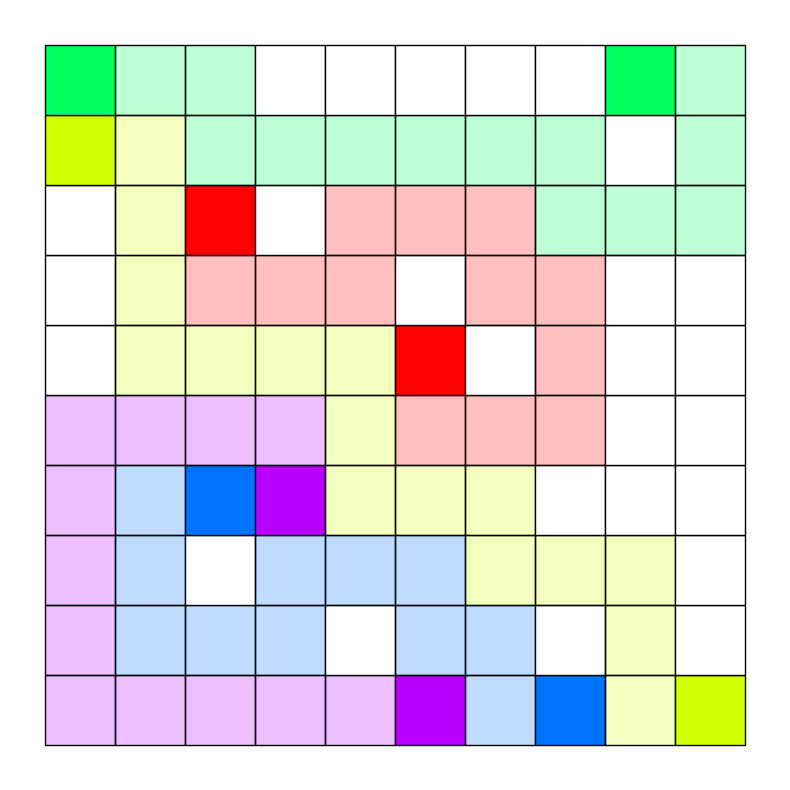

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[0]
print(solved_board)
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
print(solved_board)
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness000.png", dpi=300)

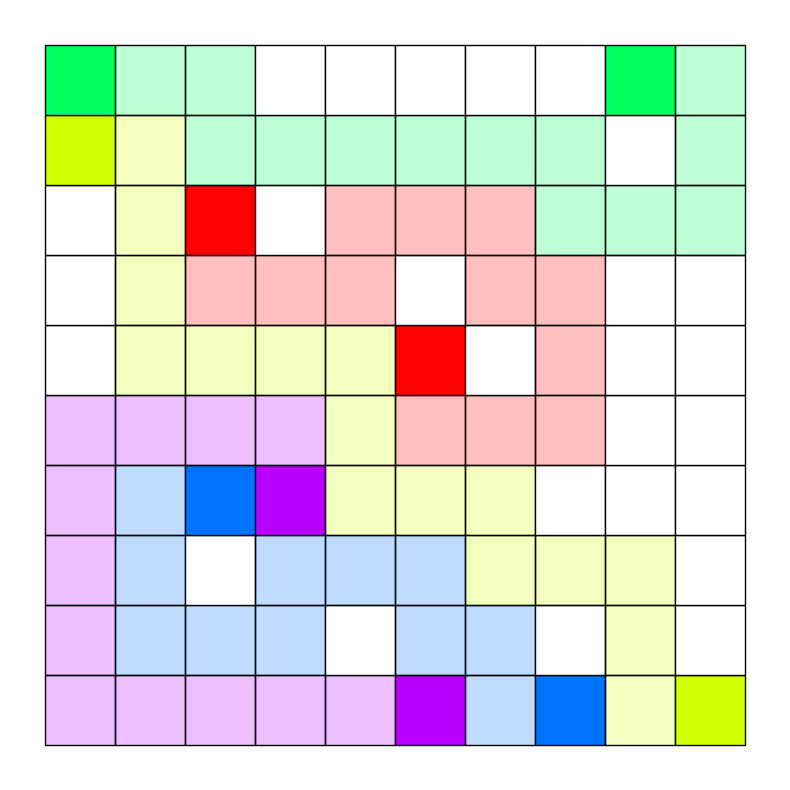

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[1]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness050.png", dpi=300)

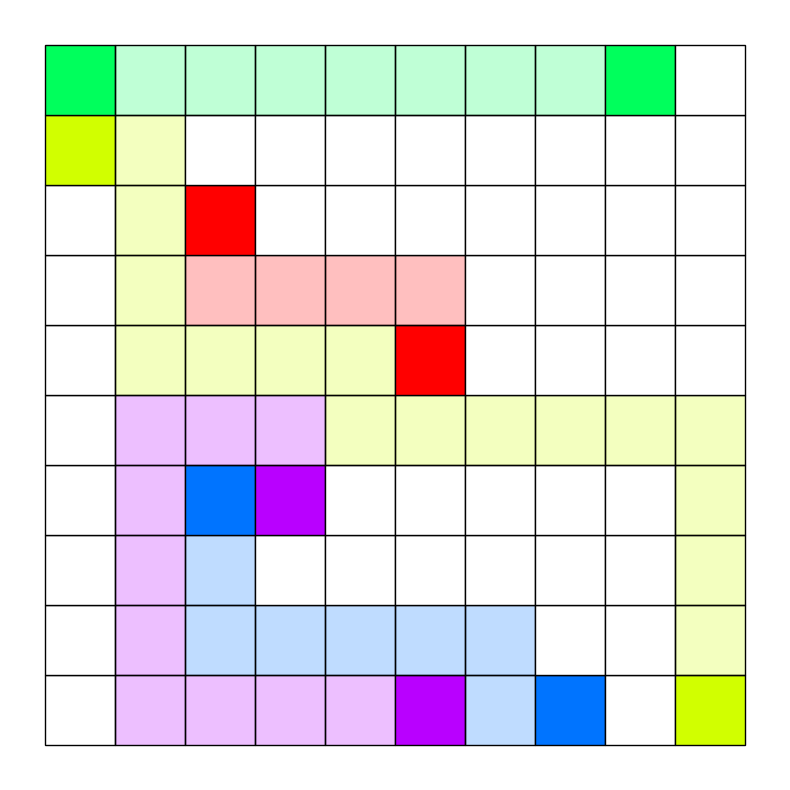

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[2]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness100.png", dpi=300)

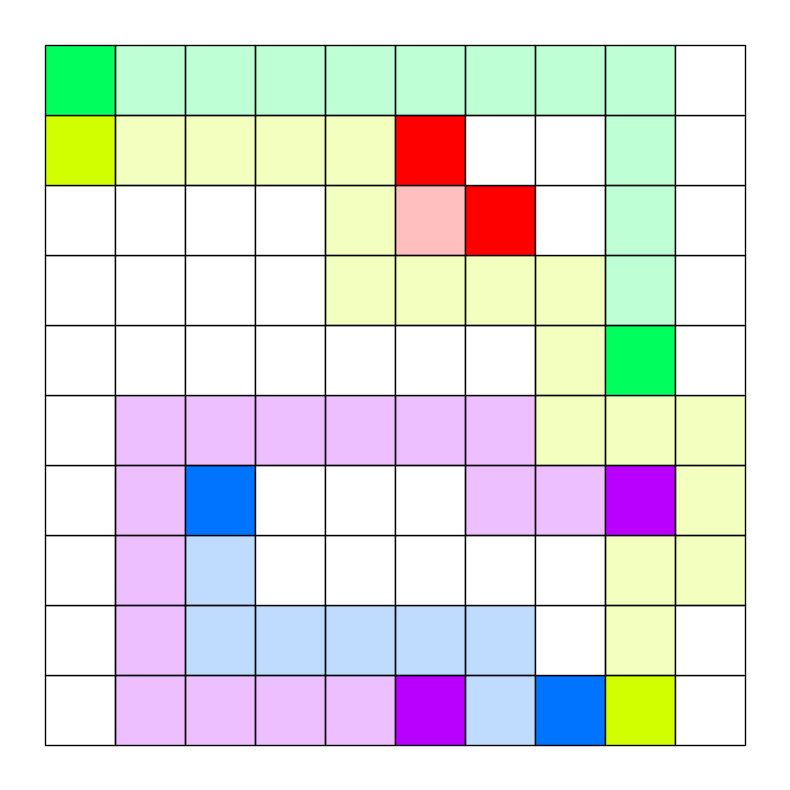

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[3]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness100.png", dpi=300)

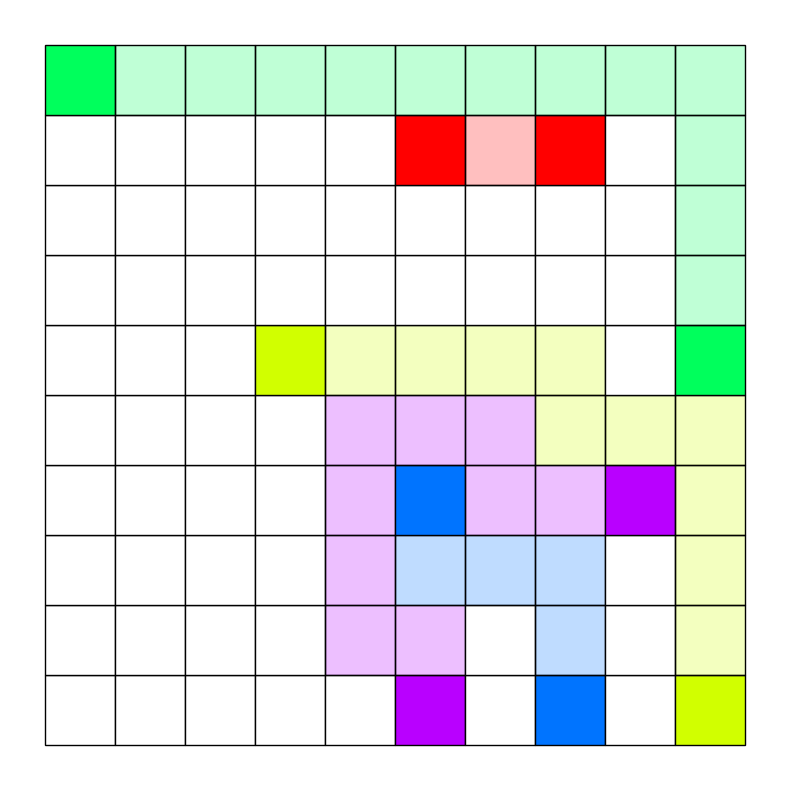

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[4]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness100.png", dpi=300)

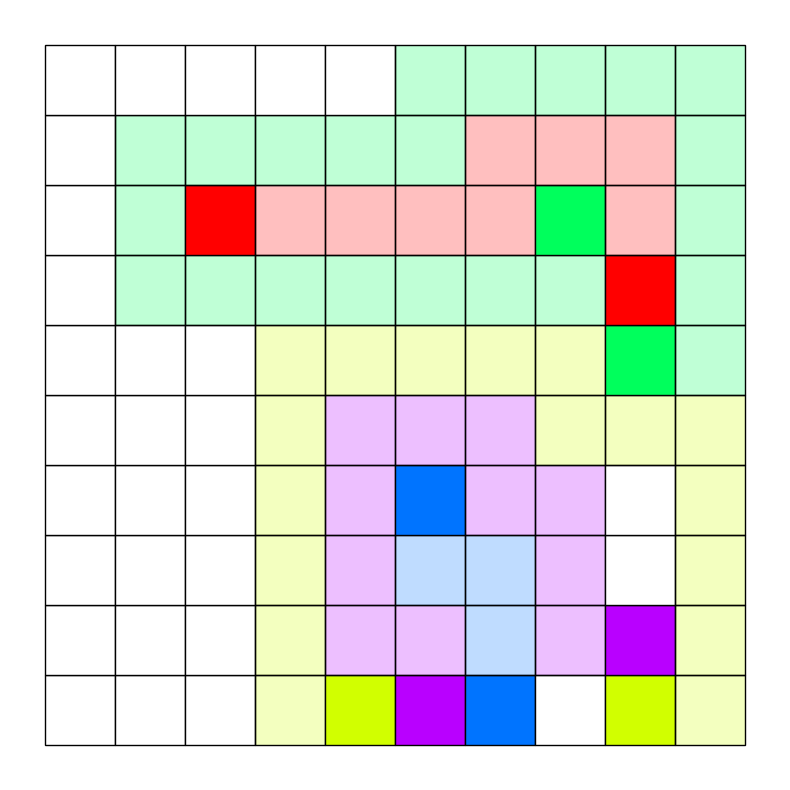

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[5]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness100.png", dpi=300)

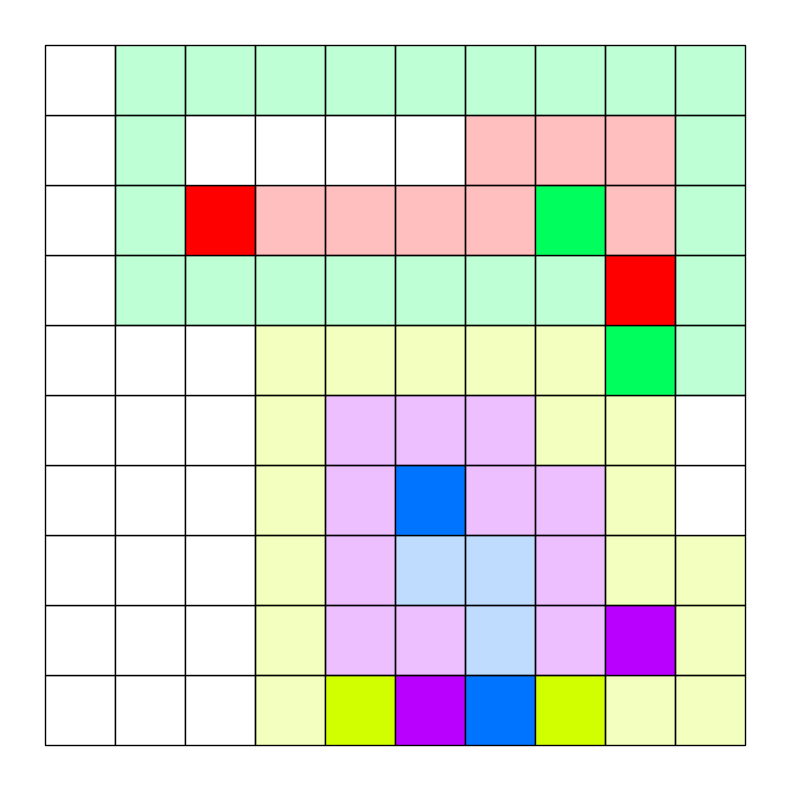

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[6]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness100.png", dpi=300)

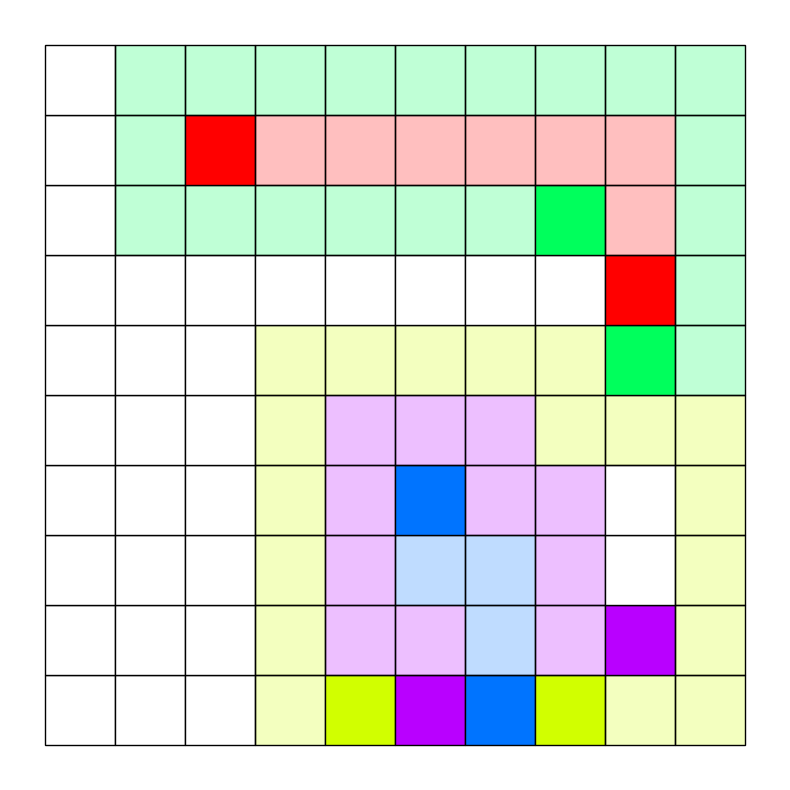

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[7]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness100.png", dpi=300)

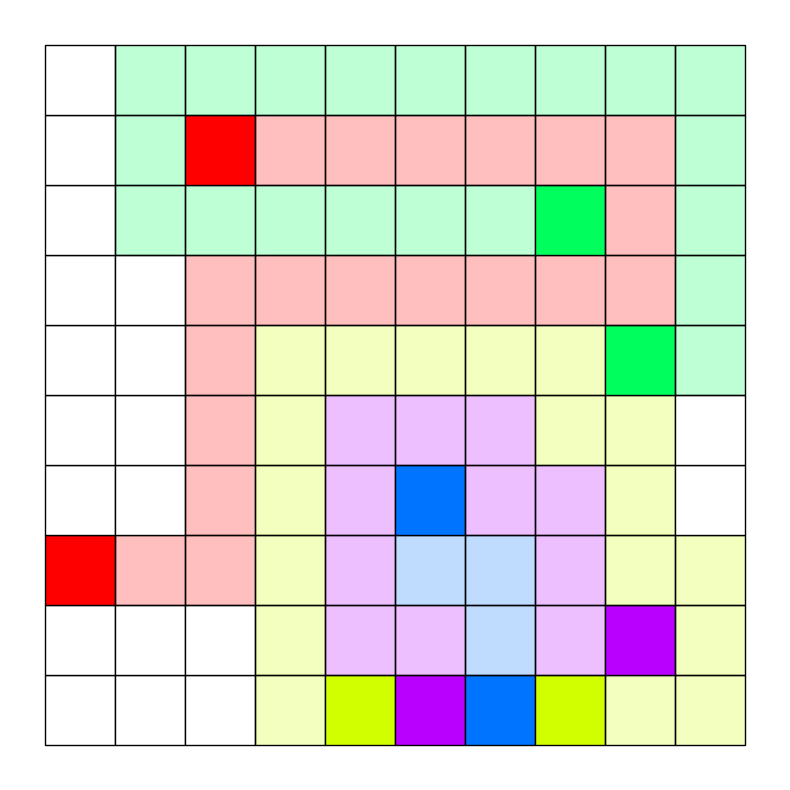

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[8]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness100.png", dpi=300)

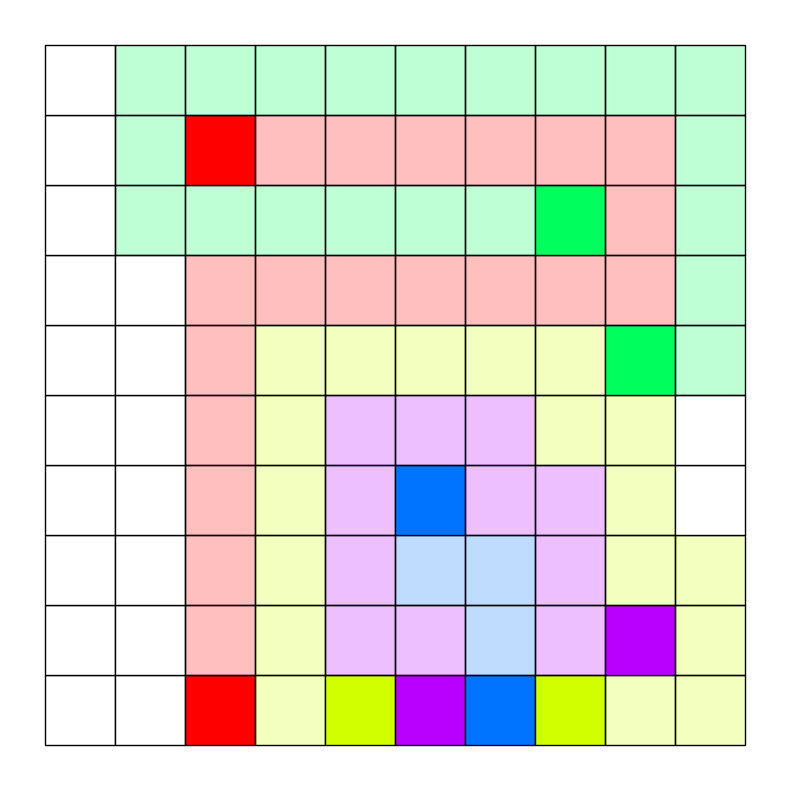

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

#env.render(states[-1])
solved_board = solved_boards[9]
solved_board = solved_board - (((solved_board %3)==0) & (solved_board!=0))
state.grid = solved_board
env.render(state)
#plt.savefig("/home/randy/Downloads/randomseed_randomness100.png", dpi=300)